## Import libraries

In [18]:
import os
import pyxdf # xdf file importation
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from my_functions import *
# library for creating filters
from scipy.signal import butter, iirnotch, filtfilt, welch, periodogram
%matplotlib widget


In [19]:
plt.close("all")  # close all figure windows

## Initialization

 ### File selection and signal loading (Ramdani signal)

In [20]:
# Define the xdf file path
FILENAME = "EEG_1channel_1000Hz.txt"
# FILENAME="020_DesMar_20211129_1_c.xdf"
# path=os.path.normpath("../DAT/Input/001_MolLud_20201112_1_c.xdf")
path = os.path.normpath("DAT/INPUT/"+FILENAME)


In [21]:
EEG_amplitudes= np.loadtxt(path,dtype=float,delimiter=",")

Srate=1000
N=len(EEG_amplitudes)

In [22]:
EEG_amplitudes_centered=EEG_amplitudes-np.mean(EEG_amplitudes)

## Signal plots and their PSD (see function details at end of notebook)

(10201,)
N:  10201
duration:  10.201
time_vector shape:  (10201,)


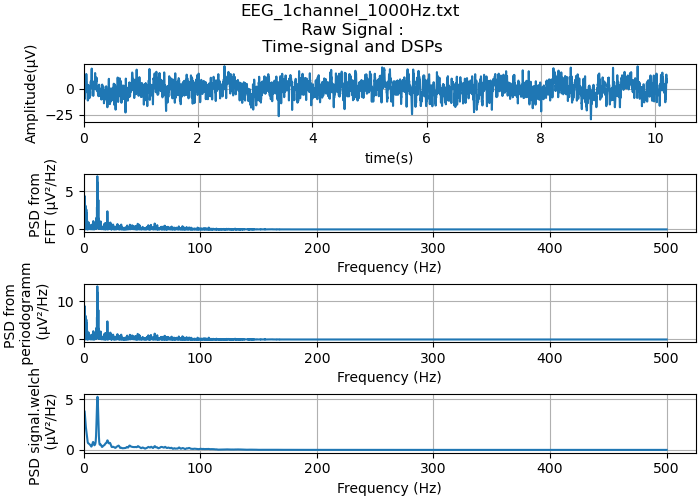

In [23]:
print(EEG_amplitudes.shape)
#the plot_signal_time_dsps function is called from the script my_functions.py
_,_,_=plot_signal_time_dsps(fig_number=1,signal=EEG_amplitudes,sample_rate=Srate,signal_name=FILENAME + "\n Raw Signal")

N:  10201
duration:  10.201
time_vector shape:  (10201,)


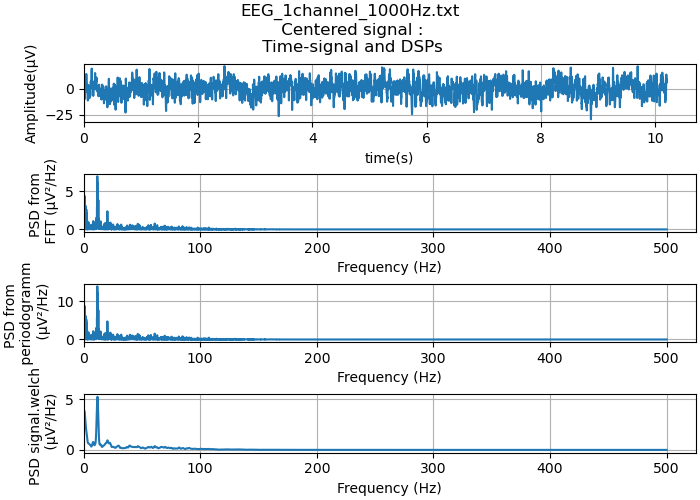

In [24]:
PSD_fft_python,PSD_p_python,PSD_w_python=plot_signal_time_dsps(fig_number=2,signal=EEG_amplitudes_centered,sample_rate=Srate,signal_name=FILENAME+"\n Centered signal")

## PSD Result comparison between matlab and python

### Importing matlab's PSD estimation results

In [25]:
FILENAME2="MATLAB_EEG_PSDs_data_1000Hz"
my_data = np.genfromtxt("./DAT/OUTPUT/"+FILENAME2+'.csv', delimiter=';',skip_header=1)
PSD_fft_matlab=my_data[:,0:2]   #1ere colonne frequences, 2e resultats PSD
PSD_p_matlab=my_data[:,2:4]     #1ere colonne frequences, 2e resultats periodogram()
PSD_w_matlab=my_data[:,4:6]     #1ere colonne frequences, 2e resultats welch

### Results data format comparison: matlab vs python over 3 methods (squared FFT, periodogram(),welch method)

In [26]:
print(np.unique(PSD_fft_python[:,0]==PSD_fft_matlab[:,0]))
print(np.unique(PSD_p_python[:,0]==PSD_p_matlab[:,0]))
print(np.unique(PSD_w_python[:,0]==PSD_w_matlab[:,0]))

[False  True]
[False  True]
[False  True]


- we can find identical and differing frequency values for each method between python and matlab

In [27]:
print(np.unique(PSD_fft_python[:,1]==PSD_fft_matlab[:,1]))
print(np.unique(PSD_p_python[:,1]==PSD_p_matlab[:,1]))
print(np.unique(PSD_w_python[:,1]==PSD_w_matlab[:,1]))

[False  True]
[False]
[False  True]


- we can find identical and differing PSD values for each method between python and matlab

<u>CCL:</u> Python and Matlab results are similar, but to what extent?

### Difference in PSD estimation methods according to language (python vs matlab)

#### Root mean square error (RMSE) of the difference between the python and matlab distributions for each PSD estimation method

In [28]:
#On étudie l'écart entre deux distributions

def rms(python,matlab,name:str): #litteral formula
    """
    Compute the root mean squared error of two series 
    """
    #rms=np.sqrt(((python - matlab) ** 2).mean())

    diff=python-matlab
    squared_diff=diff**2
    mean_squared_diff=np.mean(squared_diff)
    rms=np.sqrt(mean_squared_diff)
    print(name+" = ",rms," (µV²/Hz)")
    return rms

In [29]:
rms_fft=rms(PSD_fft_python[:,1],PSD_fft_matlab[:,1],"rms_fft")
rms_p=rms(PSD_p_python[:,1],PSD_p_matlab[:,1],"rms_p")
rms_w=rms(PSD_w_python[:,1],PSD_w_matlab[:,1],"rms_w")
rms_python_w_vs_fft=rms(PSD_fft_python[:,1],PSD_w_python[:,1],"rms_python_w_vs_fft") #difference between python's PSD estimation via fft vs python's welch function

rms_fft =  2.4733283808304315e-16  (µV²/Hz)
rms_p =  0.249800345032278  (µV²/Hz)
rms_w =  3.310000807880911e-16  (µV²/Hz)
rms_python_w_vs_fft =  0.2401652639922246  (µV²/Hz)


<u>Observation on welch</u>

Check window parameter for scipy equivalent to matlabs:
- with window parameter set to window="hamm"               : rms = 0.08288641753310991
- with window parameter set to window=signal.hamming(1000) : rms = 0.08278399915754926

Detrending:
- without specifying detrend (with hamming(1000)) : rms_w = 0.08278399915754926
- with detrend=False option   (with hamming(1000)): rms_w = 3.310000807880911e-16



CCL : python scipy.welch must use detrend=False. if argument is not specified, it defaults to  "constant" and removes the constent component, whereas in matlab there is not default detrending of the signal.



<u>Observation on periodogram</u>

Scipy periodogram function relies on the welch function, ~~which has a default overlap of 50%~~(not here cf git code) unlike matlab's function which is based on fft function and has a default overlap value of 0%.

Since scipy's periodogram is a welch with no overlap, and matlab's periodogram is an fft (of the autocor?) if we compare python's PSDs obtained via welch and fft we should have similar rms:
- rms_p =  0.249800345032278  (µV²/Hz) (python vs matlab  periodogram)
- rms_python_w_vs_fft =  0.2401652639922246  (µV²/Hz) (python fft vs python welch)

CCL: the "high" rmse between the matlab and python periodogram functions in comparison to the two other method of PSD estimation (welch, fft) may be due to the different algorithm behind the periodogram() functions.

Sources:

- https://stackoverflow.com/questions/17130795/periodogram-in-octave-matlab-vs-scipy/17310061#17310061

- https://github.com/scipy/scipy/blob/28697172c55070d61ee916f9d784c6a4ffa49191/scipy/signal/_spectral_py.py#L157-L294

- https://gist.github.com/jonbrennecke/11148249#file-periodogram-m-L21



#### Absolute difference at each frequency between the python and matlab PSD result distributions

In [30]:
def cv_percent(python,matlab):
    diff=python-matlab
    squared_diff=diff**2
    var=np.sqrt(squared_diff)
    mean=(python+matlab)/2
    cv=(var/mean)*100
    return cv

def abs_distance(python,matlab):
    diff=python-matlab
    absolute_diff=abs(diff)
    return(absolute_diff)

cv_fft=cv_percent(PSD_fft_python[:,1],PSD_fft_matlab[:,1])
cv_p=cv_percent(PSD_p_python[:,1],PSD_p_matlab[:,1])
cv_w=cv_percent(PSD_w_python[:,1],PSD_w_matlab[:,1])

absdiff_fft=abs_distance(PSD_fft_python[:,1],PSD_fft_matlab[:,1])
absdiff_p=abs_distance(PSD_p_python[:,1],PSD_p_matlab[:,1])
absdiff_w=abs_distance(PSD_w_python[:,1],PSD_w_matlab[:,1])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


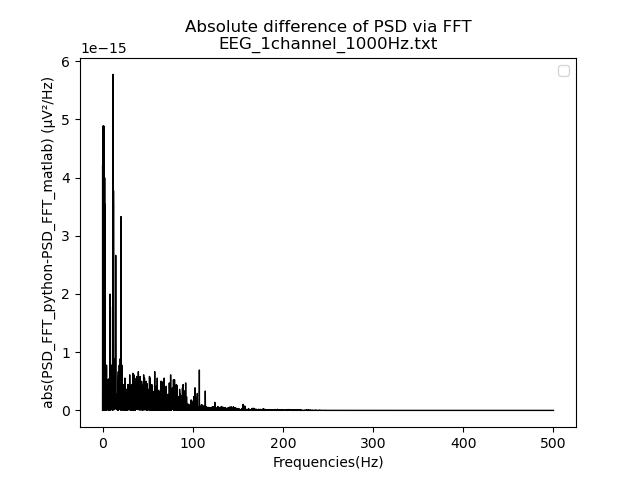

In [31]:
single_plot(FILENAME,fig_number=3,
            x=PSD_fft_python[:,0],y=absdiff_fft,
            fig_title="Absolute difference of PSD via FFT",
            ylabel="abs(PSD_FFT_python-PSD_FFT_matlab) (µV²/Hz)",
            xlabel="Frequencies(Hz)")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


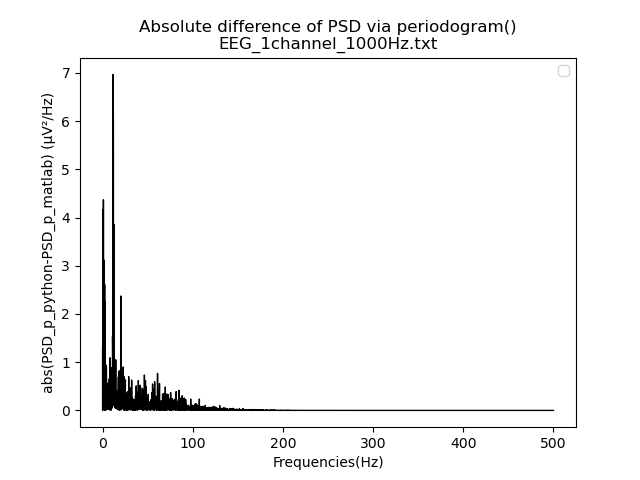

In [32]:
single_plot(FILENAME,fig_number=4,
            x=PSD_p_python[:,0],y=absdiff_p,
            fig_title="Absolute difference of PSD via periodogram()",
            ylabel="abs(PSD_p_python-PSD_p_matlab) (µV²/Hz)",
            xlabel="Frequencies(Hz)")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


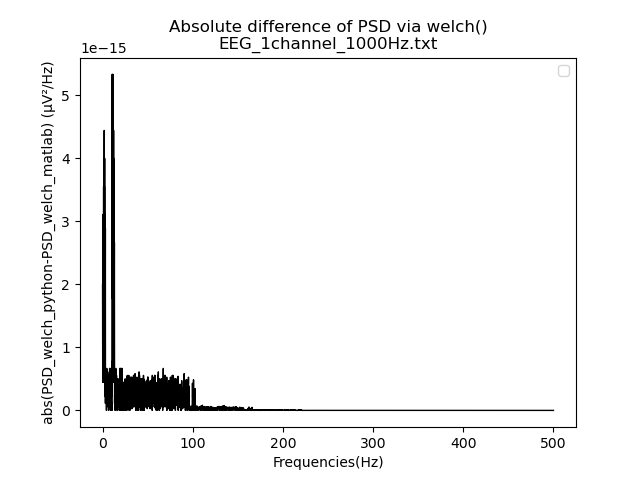

In [33]:
single_plot(FILENAME,fig_number=5,
            x=PSD_w_python[:,0],y=absdiff_w,
            fig_title="Absolute difference of PSD via welch()",
            ylabel="abs(PSD_welch_python-PSD_welch_matlab) (µV²/Hz)",
            xlabel="Frequencies(Hz)")

#### Code of the function used to compute the PSD of the time signal and to display the plots 

In [34]:
#code de la Fonction personalisée utilisée plus haut 

def plot_signal_time_dsps(fig_number: int, signal: np.ndarray, sample_rate: int, signal_name: str):
    """
    Computes the PSD of the signal with 3 methods (via FFT,and via periodogram and welch scipy functions) 
    and plots the time signal alongside its PSDs. 
    The function also returns the results as 3 2D np.arrays for each method as a couple of columns (frequencies,PSD).
    """
    N = len(signal)
    print("N: ", N)
    duration = N/sample_rate
    print("duration: ", duration)
    time_vector = np.arange(0, duration, 1/sample_rate)
    print("time_vector shape: ", time_vector.shape)

    # compute FFT of the signal
    signal_fft = np.fft.fft(signal)
    signal_frequency_vector = np.fft.fftfreq(len(signal), 1/sample_rate)

    # Only keep the positive frequencies and associated amplitudes

    signal_frequency_vector = signal_frequency_vector[0:(
        (len(signal_frequency_vector)//2)+1)]  # +1 due to python intervals

    signal_fft = signal_fft[0:((len(signal_fft)//2)+1)]

    # compute PSD via FFT
    psd_from_fft = (np.abs(signal_fft)**2)/(N*sample_rate)

    # compute PSD via periodogram
    freq1, Pxx_density1 = periodogram(
        signal,  fs=sample_rate, window=boxcar(N), detrend=False)
    # print(type(psd_from_periodogram))
    # computes DSP of the signal via scipy.signal.welch
    freq2, Pxx_density2 = welch(signal, fs=sample_rate, window=hamming(1000),
                                nperseg=1000, noverlap=500, nfft=N, detrend=False,
                                axis=0)

    # column stack frequency with psd results for each method
    PSD_fft = np.column_stack((signal_frequency_vector, psd_from_fft))
    PSD_p = np.column_stack((freq1, Pxx_density1))
    PSD_w = np.column_stack((freq2, Pxx_density2))

    figure, axis = plt.subplots(4, figsize=(
        7, 5), layout="constrained", num=fig_number)
    figure.suptitle(signal_name + " :\n Time-signal and DSPs")

    # plot time signal
    axis[0].plot(time_vector, signal)
    # axis[0].set_title('Time signal')
    axis[0].set_ylabel("Amplitude(µV)")
    axis[0].set_xlabel("time(s)")
    axis[0].set_xlim(0)
    axis[0].grid()

    # plot signal's DSP via FFT
    axis[1].plot(signal_frequency_vector, psd_from_fft)
    # axis[1].set_title('PSD from FFT')
    axis[1].set_xlim(0)
    axis[1].set_ylabel("PSD from \n FFT (µV²/Hz)")
    axis[1].set_xlabel("Frequency (Hz)")
    axis[1].grid()

    # plot signal's DSP via periodogramm
    axis[2].plot(freq1, Pxx_density1)
    # axis[2].set_title('PSD from periodogramm (µV²/Hz)')
    axis[2].set_xlim(0)
    axis[2].set_ylabel("PSD from \n periodogramm \n (µV²/Hz)")
    axis[2].set_xlabel("Frequency (Hz)")
    axis[2].grid()

    # plot signal's DSP via scipy.signal.welch
    axis[3].plot(freq2, Pxx_density2)
    # axis[3].set_title('DSP')
    axis[3].set_xlim(0)
    axis[3].set_ylabel("PSD signal.welch \n (µV²/Hz)")
    axis[3].set_xlabel("Frequency (Hz)")
    axis[3].grid()
    return PSD_fft, PSD_p, PSD_w